##Google Colab Stuff

In [4]:
import os
os.chdir('/content')

from google.colab import files

uploaded = files.upload()

!ls

Saving ssh.tar.gz to ssh.tar.gz
sample_data  ssh.tar.gz


In [5]:
#Remove the .ssh Folder if it already exists
!rm -rf /root/.ssh

#Create a new .ssh folder
!mkdir /root/.ssh

#Unzip the archive file
!tar xzvf ssh.tar.gz

#Copy the files to /root/.ssh
!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab && rm -rf ssh.tar.gz
!chmod 700 /root/.ssh

#Add the git server as a ssh known host
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/id_rsa_colab
ssh-colab/config
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6


In [6]:
#Run the agent, then run `ssh-add /root/.ssh/id_rsa_colab` in the prompt, optionally followed by `ssh-add -l` to verify, finally type `exit`
!ssh-agent /bin/bash

bash: cannot set terminal process group (117): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@b3e039fb3617: /contentroot@b3e039fb3617:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (pankajb64@gmail.com)
]0;root@b3e039fb3617: /contentroot@b3e039fb3617:/content# exit
exit


In [0]:
!git config --global user.email "pankajb64@gmail.com"
!git config --global user.name "pankajb64"

In [8]:
!git clone git@github.com:deepskies/stronglensbnns.git

Cloning into 'stronglensbnns'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 409 (delta 164), reused 390 (delta 145), pack-reused 0
Receiving objects: 100% (409/409), 7.00 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (164/164), done.


##Begin Notebook

In [0]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torchvision
import torchvision.transforms as transforms

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [0]:
os.chdir('stronglensbnns/src/notebooks/')

In [0]:
#add the bayescnn to import path - https://stackoverflow.com/a/35273613/7154530
module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
from preprocessing.houses_preprocessing import load_house_attributes, process_house_attributes

In [18]:
#@title
net_type = 'houses-nn'
dataset = 'houses'
#net_type = 'alexnet'
#dataset = 'mnist'
outputs = 10
inputs = 1
regression = True
resume = False
start_epoch = 0
n_epochs = 200 #set to 10 for MNIST, 30 for cifar10, and 10 for house pricing
lr = 0.1
weight_decay = 0.1
num_samples = 1
beta_type = "Blundell"
resize=32
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256
# percentage of training set to use as validation
valid_size = 0.2
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = []
torch.autograd.set_detect_anomaly(True)

In [0]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

In [50]:
print("| Preparing HOUSES dataset...")
sys.stdout.write("| ")
df = load_house_attributes('../../data/bayesiancnn/Houses-dataset/HousesInfo.txt')
maxPrice = 2000000
df = df[df['price'] < maxPrice]
(train, test) = train_test_split(df, test_size=0.25, random_state=42)
#maxPrice = train["price"].max()
trainY = train["price"]/maxPrice
testY = test["price"]/maxPrice
(trainX, testX) = process_house_attributes(df, train, test)
tensor_x_train = torch.stack([torch.Tensor(i) for i in trainX]) # transform to torch tensors
tensor_y_train = torch.stack([torch.Tensor(i) for i in trainY.values.reshape(-1, 1)])
trainset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset
tensor_x_test = torch.stack([torch.Tensor(i) for i in testX]) # transform to torch tensors
tensor_y_test = torch.stack([torch.Tensor(i) for i in testY.values.reshape(-1, 1)])
testset = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset
outputs = 1
inputs = trainX.shape[1]
regression = True
lr = 1e-3
weight_decay = 1e-3
classes = ('Regression') #dummy
batch_size = 32
output_names = ['house prices scaled']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

| Preparing HOUSES dataset...
| 

In [0]:
(tr, ts) = train_test_split(df, test_size=0.25, random_state=42)

In [0]:
hidden_units = 4
net = nn.Sequential(nn.Linear(inputs, hidden_units),
                     nn.ReLU(),
                     nn.Linear(hidden_units, outputs))

if use_cuda:
    net.cuda()

criterion = torch.nn.MSELoss()

In [0]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 160):
        optim_factor = 3
    elif(epoch > 120):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [0]:
#@title
def train(epoch):
    net.train()
    train_loss = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, lr))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader):
        x = inputs_value.view(-1, inputs).repeat(num_samples, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs = net(x)
        #print(outs[0], y[0])
        #print(y)
        loss = criterion(outs, y)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss, train_loss))

        sys.stdout.flush()
        
    return train_loss

In [0]:
#@title 
def test(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        x = inputs_value.view(-1, inputs).repeat(num_samples, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
    
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs = net(x)
        
        loss = criterion(outs, y)

        test_loss += loss.data.item()
        loss = loss.data.item()
    
    
    print('\n| Validation Epoch #%d\t\t\tLoss: %.4f' %(epoch, test_loss))

    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if save_epoch:
       if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
       
       save_point = './checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if test_loss < best_loss:
        print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
        best_loss = test_loss
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_nn.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    return test_loss

In [38]:
#@title
elapsed_time = 0
saved_epochs = []

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(start_epoch, start_epoch+n_epochs):
    start_time = time.time()

    tloss = train(epoch)
    train_losses.append(tloss)
    if (epoch%1 == 0):
        vloss = test(epoch, save_epoch = True )
        saved_epochs.append(epoch)
        val_losses.append(vloss)
    else:
        vloss = test(epoch)
        val_losses.append(vloss)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

if not regression:    
  print('\n Test results : Acc@1 = %.2f%%' %(best_acc))
else:
  print('\n Test results : Loss = %.2f' %(best_loss))


=> Training Epoch #0, LR=0.0010
| Epoch [  0/199] Iter[  9/  9]		Iter Loss: 0.2495, Cumulative Loss: 2.3079
| Validation Epoch #0			Loss: 0.7370
Saved Epoch 0 as ./checkpoint-houses-nn-houses-epoch-0.pt
| Elapsed time : 0:00:00

=> Training Epoch #1, LR=0.0010
| Epoch [  1/199] Iter[  9/  9]		Iter Loss: 0.3546, Cumulative Loss: 2.1639
| Validation Epoch #1			Loss: 0.6627
Saved Epoch 1 as ./checkpoint-houses-nn-houses-epoch-1.pt
| Elapsed time : 0:00:00

=> Training Epoch #2, LR=0.0010
| Epoch [  2/199] Iter[  9/  9]		Iter Loss: 0.1833, Cumulative Loss: 1.8527
| Validation Epoch #2			Loss: 0.5919
Saved Epoch 2 as ./checkpoint-houses-nn-houses-epoch-2.pt
| Elapsed time : 0:00:00

=> Training Epoch #3, LR=0.0010
| Epoch [  3/199] Iter[  9/  9]		Iter Loss: 0.2222, Cumulative Loss: 1.6799
| Validation Epoch #3			Loss: 0.5240
Saved Epoch 3 as ./checkpoint-houses-nn-houses-epoch-3.pt
| Elapsed time : 0:00:00

=> Training Epoch #4, LR=0.0010
| Epoch [  4/199] Iter[  9/  9]		Iter Loss: 0.1664,

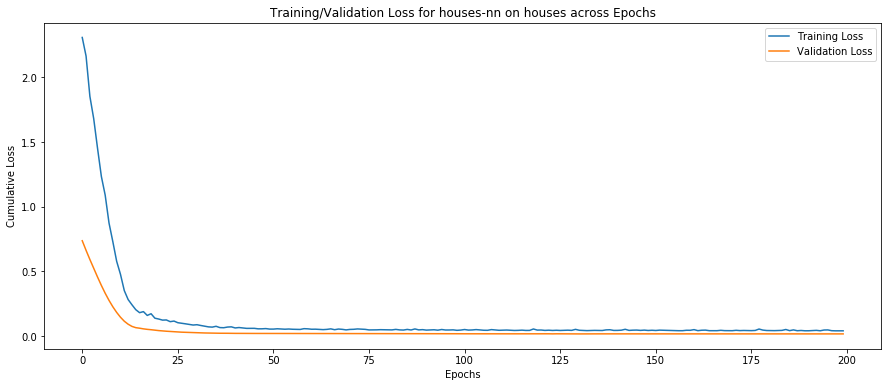

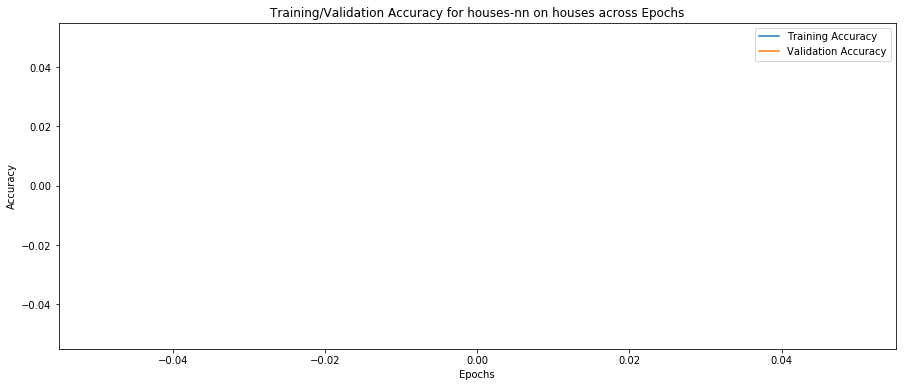

In [39]:
#@title
def plot_loss():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
  plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
  plt.title('Training/Validation Loss for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Cumulative Loss')
  plt.legend()
  
def plot_acc():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
  plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
  plt.title('Training/Validation Accuracy for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
plot_loss()
plot_acc()

In [0]:
def get_predictions(dataloader):
    predsY = []
    labs = []
    for batch_idx, (inputs_value, targets) in enumerate(dataloader):
        x = inputs_value.view(-1, inputs).repeat(1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs = net(x)
        predsY.extend(outs.detach().cpu().numpy().squeeze())
        labs.extend(y.detach().cpu().numpy().squeeze())
    return np.array(predsY), np.array(labs)

In [0]:
def scatter_plots():
    preds, labs = get_predictions(testloader)
    #print(preds.shape)
    #print(testY.shape)
    trainY_mean = np.mean(trainY)
    #print(preds)
    lr = LinearRegression()
    lr.fit(labs.reshape(-1, 1), preds)
    pp = lr.predict(labs.reshape(-1, 1)) 
    fig, ax = plt.subplots(figsize=(15,6))
    for j in range(outputs):
      sns.scatterplot(x=testY, y=preds, ax=ax)
      ax.plot(labs, labs, '--r', label='ideal relationship line')
      ax.plot(labs, [trainY_mean for l in labs], '--g', label='line if predicting train mean')
      ax.plot(labs, pp, '--b', label='current relationship line')
      #ax.set_xlim([0,1])
      #ax.set_ylim([0,1])
      ax.set_xlabel('{}: true'.format(output_names[j]))
      ax.set_ylabel('{}: predicted'.format(output_names[j]))
      ax.legend()

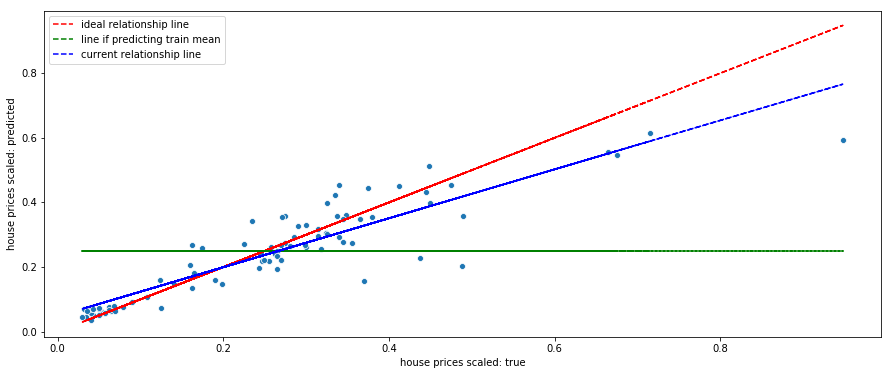

In [58]:
scatter_plots()

In [0]:
np.mean(testY)

0.2512987277777778